## Examen final se los entrego el día 23 de Noviembre. Tendrán hasta el día 26 de Noviembre para entregarlo resuelto. A las 6:55 am (antes de la clase de ese día).

## Proyecto del módulo 2 se entregará y se presentará el día 3 de diciembre (en la hora de clase).

## Asesoría para el proyecto los días 26 y 30 de Noviembre en la hora de clase.

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_close(names, start, end):
    closes = web.DataReader(names, 'yahoo', start, end)
    return closes['Adj Close'] 

In [3]:
# Descargamos datos...
names = ['TSLA', 'GOOG']
start = '01/01/2018'
end = '31/12/2020'

precios = get_close(names, start, end)

<AxesSubplot:xlabel='Date'>

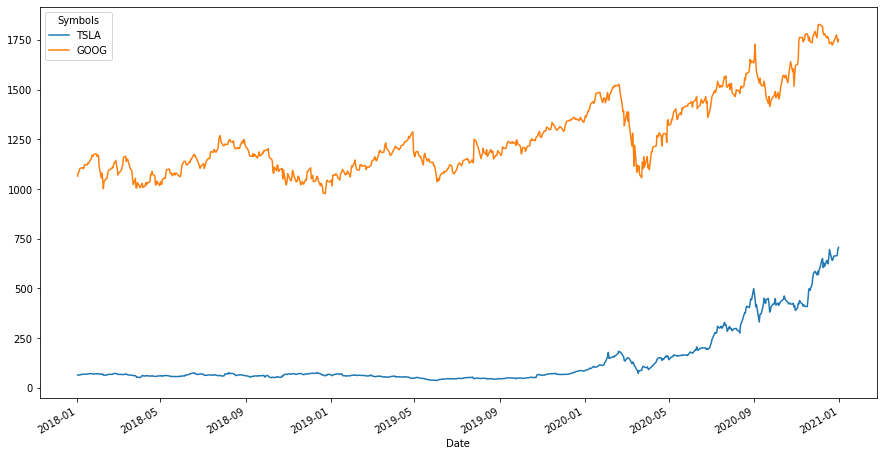

In [4]:
# Graficamos
precios.plot(figsize=(15,8))

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

<AxesSubplot:xlabel='Date'>

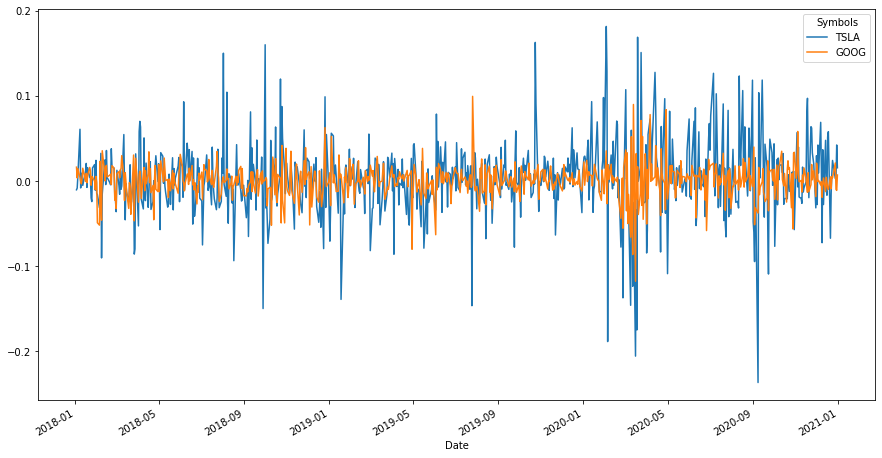

In [5]:
# Calcular rendimientos diarios y graficarlos
ret = precios.pct_change()

ret2 = np.log(precios/precios.shift())
ret2.plot(figsize=(15, 8))

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [6]:
# Calculamos media y desviación estándar
mu_TSLA = ret['TSLA'].mean()
mu_GOOG = ret['GOOG'].mean()

std_TSLA = ret['TSLA'].std()
std_GOOG = ret['GOOG'].std()

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2020, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [7]:
# Ayuda en la función np.random.randn
help(np.random.randn)  # Por defecto toma que mu = 0 y que std = 1

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
 

In [8]:
# Función que simula varios escenarios de rendimientos diarios
def sim_rend(mu, std, ndays, nscen, start_date):
    
    # Generar el rango de fechas en las que se realizará la predicción
    fechas = pd.date_range(start_date, periods=ndays)
    
    # Generar la predicción asumiendo que los rendimientos siguen una distribución normal (gaussiana)
    datos = std*np.random.randn(ndays, nscen) + mu
    
    # Generar un dataframe (tabla) con los resultados
    rendimientos_simulados = pd.DataFrame(datos, index=fechas)
    
    return rendimientos_simulados

In [9]:
# Simulamos 100 escenarios para todo el 2021
ndays = 365
nscen = 100
start_date = '01/01/2021'

rend_simu_TSLA = sim_rend(mu_TSLA, std_TSLA, ndays, nscen, start_date)
rend_simu_TSLA

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,0.022292,0.072706,0.010281,0.064438,0.004489,-0.035556,0.057452,0.049951,-0.012883,-0.000670,...,0.044687,-0.000960,0.058542,-0.003014,0.000518,0.065266,0.005193,0.062420,-0.072558,0.021777
2021-01-02,0.053509,0.018691,0.020561,0.038159,-0.062412,-0.020740,-0.055347,-0.017145,0.039329,0.011734,...,0.002090,-0.024091,0.008496,-0.030845,-0.002188,0.013336,-0.027761,-0.012604,-0.010824,0.026091
2021-01-03,-0.075444,-0.047316,-0.040220,0.018825,0.002492,0.013598,-0.005425,0.010257,0.113189,0.011003,...,0.010096,-0.054433,-0.058930,-0.030026,-0.031129,-0.022966,-0.021107,-0.042247,0.089612,-0.025045
2021-01-04,-0.047778,0.006981,0.023313,0.056247,-0.018441,-0.051947,-0.013070,-0.068007,0.018908,0.059230,...,0.028775,0.022197,0.009789,0.040841,-0.018754,0.036204,-0.032678,-0.030462,-0.072383,0.044457
2021-01-05,-0.048609,-0.033021,-0.060123,0.053195,-0.005826,0.051766,0.056486,-0.019445,0.005808,0.006202,...,-0.013031,0.023467,0.020959,0.055643,-0.046510,0.015474,-0.074213,0.061743,-0.086987,0.033208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.007169,0.002928,0.076772,0.007400,-0.040972,0.049469,-0.066772,-0.069142,0.044242,-0.041567,...,-0.037320,0.125539,-0.040725,-0.055637,0.051161,-0.031848,0.049157,0.010599,-0.030788,-0.048958
2021-12-28,0.005483,0.021519,0.075861,-0.012799,-0.036159,0.059712,-0.025045,-0.023293,0.077597,-0.036734,...,0.052122,0.049902,0.007598,0.033088,-0.001257,-0.069324,0.136342,-0.028340,0.067513,0.048056
2021-12-29,-0.041436,-0.051569,0.030924,-0.064191,-0.001431,-0.077524,-0.030759,0.079645,-0.053963,-0.001779,...,0.048879,0.012851,0.060579,0.031602,0.038968,-0.007789,0.018165,0.005158,0.041597,0.026711
2021-12-30,-0.033871,-0.045844,-0.086446,0.003742,0.105367,-0.022346,-0.047520,-0.004170,0.041367,0.031181,...,0.064514,-0.035896,-0.010894,-0.008917,-0.032490,-0.057520,0.010900,0.015646,0.039242,0.060671


<AxesSubplot:>

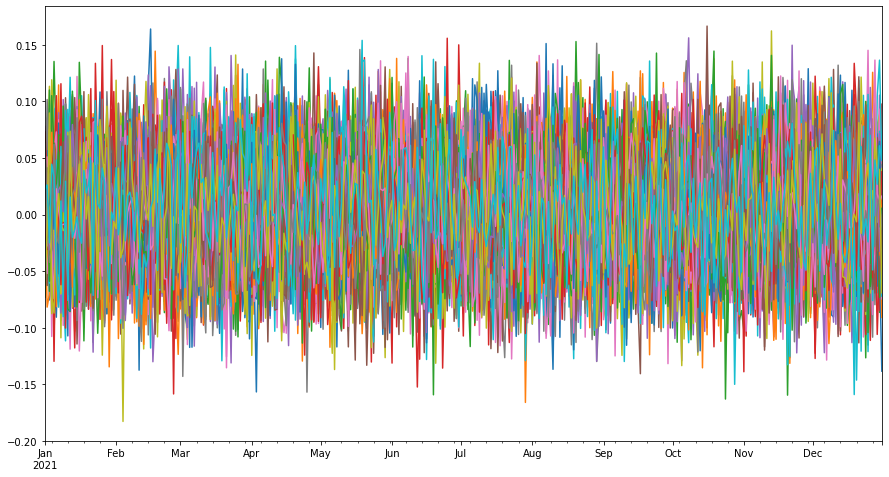

In [10]:
# Mostrar
rend_simu_TSLA.plot(figsize=(15,8), legend=False)

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2020.

Con los rendimientos, calculamos los precios de cierre...

In [11]:
# Obtenemos los precios. Transformar los rendimientos simulados del 2021 a precios de acción simulados del 2021.
precios_simulados_TSLA = precios['TSLA'][-1]*(1+rend_simu_TSLA).cumprod()
precios_simulados_TSLA

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,721.400536,756.976727,712.924917,751.141667,708.837847,680.578884,746.212174,740.919043,696.578860,705.197007,...,737.204115,704.992871,746.981342,703.542963,706.035488,751.726328,709.334536,749.717845,654.468171,721.037213
2021-01-02,760.002088,771.125552,727.583715,779.804543,664.597870,666.463729,704.911805,728.216222,723.974270,713.471454,...,738.744934,688.008743,753.327660,681.842359,704.490895,761.751024,689.642519,740.268588,647.384395,739.849839
2021-01-03,702.664344,734.639001,698.320237,794.484277,666.253777,675.526044,701.087404,735.685237,805.920299,721.321785,...,746.203099,650.558686,708.934307,661.369036,682.560833,744.256285,675.086393,708.994237,705.397512,721.320224
2021-01-04,669.092714,739.767848,714.600222,839.171706,653.967119,640.434387,691.924205,685.653802,821.158468,764.045396,...,767.675055,664.998923,715.874234,688.380137,669.760182,771.201605,653.026093,687.396852,654.338402,753.388177
2021-01-05,636.568832,715.339690,671.636080,883.811287,650.157282,673.586840,731.008079,672.321360,825.927475,768.784350,...,757.671317,680.604708,730.877955,726.683505,638.609365,783.135219,604.563000,729.838620,597.419419,778.406837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5616.025291,1667.454435,1324.405818,2242.074458,1217.603541,3455.912415,4279.089347,6528.185434,1081.391268,1635.338853,...,3819.709542,2128.013305,783.119323,1202.706139,3572.694811,2613.824612,578.772672,866.060721,2220.449227,6779.749365
2021-12-28,5646.818005,1703.335791,1424.876932,2213.378238,1173.576273,3662.270527,4171.918116,6376.123859,1165.303640,1575.266818,...,4018.802269,2234.205671,789.069439,1242.500811,3568.202785,2432.622832,657.683800,841.516780,2370.358080,7105.559034
2021-12-29,5412.836266,1615.496598,1468.940294,2071.299779,1171.896999,3378.357379,4043.594303,6883.952452,1102.420512,1572.464188,...,4215.236614,2262.916812,836.870375,1281.766049,3707.249143,2413.674859,669.630701,845.857721,2468.957984,7295.356848
2021-12-30,5229.500689,1541.436002,1341.955933,2079.051617,1295.376491,3302.865935,3851.441893,6855.248870,1148.024525,1621.494542,...,4487.180314,2181.686361,827.753163,1270.336546,3586.800322,2274.840935,676.929616,859.091963,2565.845904,7737.976655


<AxesSubplot:>

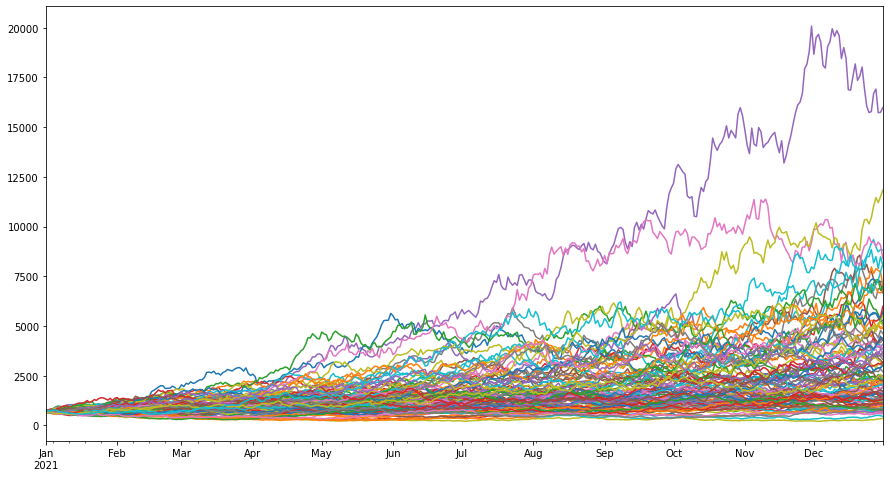

In [12]:
# Graficar
precios_simulados_TSLA.plot(figsize=(15, 8), legend=False)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [19]:
# Umbral de 110% del ultimo precio
umbral = (1 + 0.1)*(precios['TSLA'][-1])

# Fechas
dates = precios_simulados_TSLA.index

<AxesSubplot:>

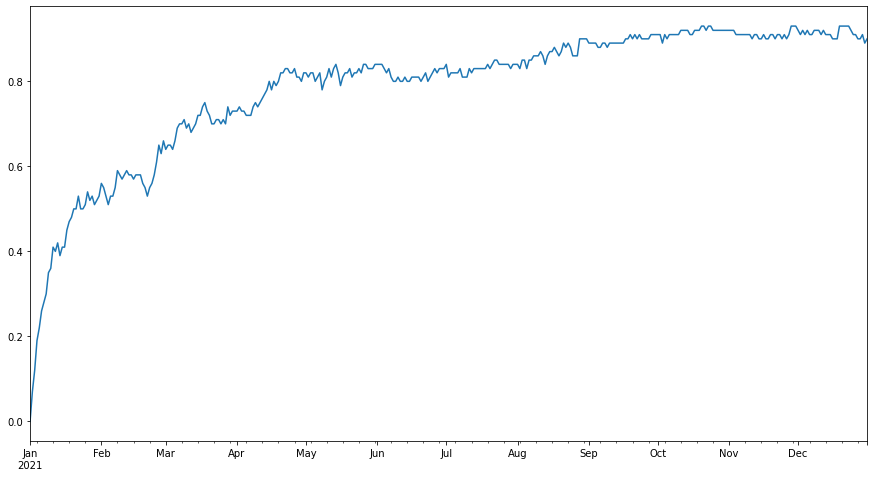

In [25]:
# Comparar cada escenario en cada fecha
TF = precios_simulados_TSLA>=umbral

# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = TF.sum(axis=1)/100

# Gráfico de probabilidad
prob.plot(figsize=(15, 8), legend=False)

In [29]:
# Descargamos datos...
# Instrumento: 
names = ['TSLA']

# Fechas de interés (inicio y fin): 
start = '01/01/2021'
end = '23/11/2021'

# Función DataReader
precios_reales = get_close(names, start, end)

<AxesSubplot:xlabel='Date'>

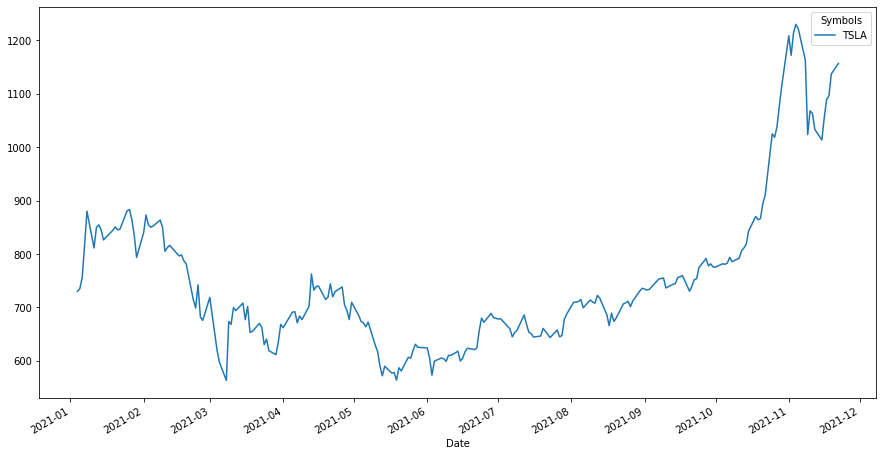

In [30]:
precios_reales.plot(figsize=(15, 8))

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>